In [1]:
# System
import os
#nltk.download('stopwords')
# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# Tools
import itertools
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

# NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from pywsd.utils import lemmatize_sentence

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import re

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,cross_val_predict

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/twitter_sentiment_data.csv')

In [3]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
sentiment    43943 non-null int64
message      43943 non-null object
tweetid      43943 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [5]:
# checking if there are any null values
df[df.isnull().any(axis=1)].head()

,sentiment,message,tweetid


# Visualization

[]

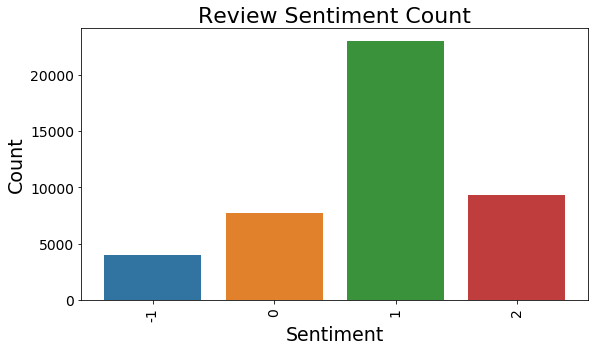

In [4]:
figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.subplot(122)
col = "sentiment"
xlabel = "Sentiment"
ylabel = "Count"
sns.countplot(df[col])
# creating titles and labels
plt.title("Review Sentiment Count")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

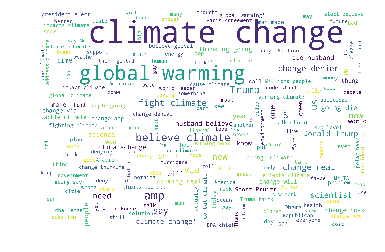

In [11]:
# generating wordcloud 

# joining tweets to a single string
words = ' '.join(df['message'])

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
# basic wordcloud without separating positive and negative tweets
wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2000
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./twitter_wordcloud.png', dpi=360)
plt.show()

# Training Model

Logistic Regression with tfidf vectorizer

In [6]:
# Define the vector of labels and matrix of features
y = df["sentiment"]
X = df["message"]
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vct_tweet=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
# Create sparse matrix from the tfidf vectorizer
tfidf_train_x = vct_tweet.fit_transform(X_train)
tfidf_test_x = vct_tweet.fit_transform(X_test)
# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression()
log_reg.fit(tfidf_train_x,y_train)
#print (tfidf_test_x.shape)
scores = cross_val_score(log_reg,tfidf_test_x, y_test)
acc = scores.mean()
print ("Accuracy: %0.2f percent" % (acc *100))

C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(8789, 22589)
Accuracy: 63.70 percent


C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Comparing two logistic regressions with different penalties

In [8]:
#set up X and y
X_train = df['message']
y_train = df['sentiment']
#set up baseline 
print (y_train.value_counts(normalize=True))
baseline = 0.3

 1    0.522541
 2    0.211092
 0    0.175568
-1    0.090799
Name: sentiment, dtype: float64


In [9]:
lr = LogisticRegression(random_state=1)

In [10]:
# initalise the vectorizer 
vector_twt = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
# fit the training data on the model
vector_twt.fit(X_train)

#transform training data into sparse matrix
X_train_twt = vector_twt.transform(X_train)

# cross val score/ predict for the four categories
twt_score = cross_val_score(lr, X_train_twt, y_train, cv=4)
print ('Tfidf Vectorizer Score:', twt_score.mean())


C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tfidf Vectorizer Score: 0.6654973690077446


In [11]:
# initalise the count vectorizer 
cvector_twt = CountVectorizer(stop_words=stopwords.words('english'))
# fit the training data on the model
cvector_twt.fit(X_train)

#transform training data into sparse matrix
X_train_cvt = cvector_twt.transform(X_train)

# cross val score/ predict
cvct_score = cross_val_score(lr, X_train_cvt, y_train, cv=4 )
print ('Count Vectorizer Score:', cvct_score.mean())

C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Count Vectorizer Score: 0.6843394180700526


In [12]:
# Transform features 
cvect = CountVectorizer(ngram_range=(1,3)) 
cvect.fit(X_train)
X_train_cvect= cvect.transform(X_train)
# fit with l1 
model_l1 = LogisticRegressionCV(penalty = 'l1',solver='liblinear',cv=4) 
model_l1.fit(X_train_cvect, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [14]:
# fit with l2
model_l2 = LogisticRegressionCV( penalty = 'l2',solver='liblinear',cv=4) 
model_l2.fit(X_train_cvect, y_train)


C:\Users\mrunm\anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [7]:
X = df
print(X["message"])

0        @tiniebeany climate change is an interesting h...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right...
2        Fabulous! Leonardo #DiCaprio's film on #climat...
3        RT @Mick_Fanning: Just watched this amazing do...
4        RT @cnalive: Pranita Biswasi, a Lutheran from ...
5        Unamshow awache kujinga na iko global warming ...
6        RT @cnalive: Pranita Biswasi, a Lutheran from ...
7        RT @CCIRiviera: Presidential Candidate #Donald...
8        RT @AmericanIndian8: Leonardo DiCaprio's clima...
9        #BeforeTheFlood Watch #BeforeTheFlood right he...
10       RT @DrDeJarnett: It's vital that the public he...
11       Bangladesh did not cause climate change, so th...
12       RT @NatGeoChannel: Watch #BeforeTheFlood right...
13       Now's the time: we need a strong #FTT that wor...
14       RT @WorldResources: Reflections on Leonardo Di...
15       RT @littoralsociety: The problem with global w...
16       RT @NatGeoChannel: One of the easiest ways to .

In [7]:
#Beautiful Soup is a library that makes it easy to scrape information from web pages.
#It sits atop an HTML or XML parser, providing Pythonic idioms for iterating, searching, and modifying the parse tree.
X["message"] = X["message"].apply(lambda x: BeautifulSoup(x, "lxml").get_text())
print(X["message"])

0        @tiniebeany climate change is an interesting h...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right...
2        Fabulous! Leonardo #DiCaprio's film on #climat...
3        RT @Mick_Fanning: Just watched this amazing do...
4        RT @cnalive: Pranita Biswasi, a Lutheran from ...
5        Unamshow awache kujinga na iko global warming ...
6        RT @cnalive: Pranita Biswasi, a Lutheran from ...
7        RT @CCIRiviera: Presidential Candidate #Donald...
8        RT @AmericanIndian8: Leonardo DiCaprio's clima...
9        #BeforeTheFlood Watch #BeforeTheFlood right he...
10       RT @DrDeJarnett: It's vital that the public he...
11       Bangladesh did not cause climate change, so th...
12       RT @NatGeoChannel: Watch #BeforeTheFlood right...
13       Now's the time: we need a strong #FTT that wor...
14       RT @WorldResources: Reflections on Leonardo Di...
15       RT @littoralsociety: The problem with global w...
16       RT @NatGeoChannel: One of the easiest ways to .

In [14]:
X["message"] = X["message"].apply(lambda x: x.lower())
print(X["message"])

0        @tiniebeany climate change is an interesting h...
1        rt @natgeochannel: watch #beforetheflood right...
2        fabulous! leonardo #dicaprio's film on #climat...
3        rt @mick_fanning: just watched this amazing do...
4        rt @cnalive: pranita biswasi, a lutheran from ...
5        unamshow awache kujinga na iko global warming ...
6        rt @cnalive: pranita biswasi, a lutheran from ...
7        rt @cciriviera: presidential candidate #donald...
8        rt @americanindian8: leonardo dicaprio's clima...
9        #beforetheflood watch #beforetheflood right he...
10       rt @drdejarnett: it's vital that the public he...
11       bangladesh did not cause climate change, so th...
12       rt @natgeochannel: watch #beforetheflood right...
13       now's the time: we need a strong #ftt that wor...
14       rt @worldresources: reflections on leonardo di...
15       rt @littoralsociety: the problem with global w...
16       rt @natgeochannel: one of the easiest ways to .

In [8]:
#Regular expression
#Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl
#replace whatever except alphabets to space
X["message"] = X["message"].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
print(X["message"])

0         tiniebeany climate change is an interesting h...
1        RT  NatGeoChannel  Watch  BeforeTheFlood right...
2        Fabulous  Leonardo  DiCaprio s film on  climat...
3        RT  Mick Fanning  Just watched this amazing do...
4        RT  cnalive  Pranita Biswasi  a Lutheran from ...
5        Unamshow awache kujinga na iko global warming ...
6        RT  cnalive  Pranita Biswasi  a Lutheran from ...
7        RT  CCIRiviera  Presidential Candidate  Donald...
8        RT  AmericanIndian   Leonardo DiCaprio s clima...
9         BeforeTheFlood Watch  BeforeTheFlood right he...
10       RT  DrDeJarnett  It s vital that the public he...
11       Bangladesh did not cause climate change  so th...
12       RT  NatGeoChannel  Watch  BeforeTheFlood right...
13       Now s the time  we need a strong  FTT that wor...
14       RT  WorldResources  Reflections on Leonardo Di...
15       RT  littoralsociety  The problem with global w...
16       RT  NatGeoChannel  One of the easiest ways to .

In [9]:
#replace tab with space
X["message"] = X["message"].apply(lambda x: re.sub("\s+", " ", x))
print(X["message"])

0         tiniebeany climate change is an interesting h...
1        RT NatGeoChannel Watch BeforeTheFlood right he...
2        Fabulous Leonardo DiCaprio s film on climate c...
3        RT Mick Fanning Just watched this amazing docu...
4        RT cnalive Pranita Biswasi a Lutheran from Odi...
5        Unamshow awache kujinga na iko global warming ...
6        RT cnalive Pranita Biswasi a Lutheran from Odi...
7        RT CCIRiviera Presidential Candidate DonaldTru...
8        RT AmericanIndian Leonardo DiCaprio s climate ...
9         BeforeTheFlood Watch BeforeTheFlood right her...
10       RT DrDeJarnett It s vital that the public heal...
11       Bangladesh did not cause climate change so the...
12       RT NatGeoChannel Watch BeforeTheFlood right he...
13       Now s the time we need a strong FTT that works...
14       RT WorldResources Reflections on Leonardo DiCa...
15       RT littoralsociety The problem with global war...
16       RT NatGeoChannel One of the easiest ways to he.

In [18]:
# Analyzing the dataset by building a vectorizer using tfidf
vect_tweet= TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 3), max_features=400, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(X.message)
# Create sparse matrix from the vectorizer
X_t = vect_tweet.transform(X.message)

# Creating a DataFrame
reviews_transformed = pd.DataFrame(X_t.todense(), index=X.index, columns=vect_tweet.get_feature_names())
reviews_transformed.head()

,act,action,action climate,action climate change,actually,address,address climate,address climate change,administration,agree,...,women,won,work,world,worse,worst,wrong,year,years,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.59888
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.223247,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000


In [10]:
y = X["sentiment"]
X = X["message"]

# define stop words
stopwords = stopwords.words('english')

#remove stopwords
vectorizer = CountVectorizer(stop_words=stopwords)

X = vectorizer.fit_transform(X)
# running a random forest on the dataset by removing stopwords using the countverctorizer
model = RandomForestClassifier(n_estimators=5, n_jobs=-1, class_weight='balanced', random_state=0)

#Evaluate a score by cross-validation
print(cross_val_score(model, X, y, cv=3))

[0.60745494 0.57570999 0.53697003]
